In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable

import os
import pyworld
import librosa
import time
import matplotlib.pyplot as plt

from preprocess import *
from model import *

torch.manual_seed(0)
np.random.seed(0)

In [2]:
model_name = "model_lambda70_f1f4m1m4"
model_dir = "./model/" + model_name

data_dir =  "./vcc2018_training"
voice_dir_list = ["VCC2SF4", "VCC2SF1", "VCC2SM4", "VCC2SM1"]
output_dir = "./converted_voices/test/" + model_name + "_training_progress"
figure_dir = "./figure/" + model_name

In [3]:
lambda_p = 70
lambda_s = 70
nb_label = len(voice_dir_list)

num_epochs = 25
batch_size = 5
learning_rate =1e-3
learning_rate_ = 1e-4
learning_rate__ = 1e-5
learning_rate___ = 1e-6
sampling_rate = 22050
num_envelope  = 36
num_mcep = 36
frame_period = 5.0
n_frames = 1024

lambda_cls=1
lambda_rec=10
lambda_gp=10

In [4]:
for v in voice_dir_list:
    if "log_f0_"+v+".npz" in  os.listdir(os.path.join(data_dir, v)):
        continue
    print("Preprocess: " + v)
    preprocess_voice(os.path.join(data_dir, v), v)

FileNotFoundError: [Errno 2] No such file or directory: './vcc2018_training/VCC2SF4'

In [122]:
data_dir2 =  "./vcc2018_evaluation"

for v in voice_dir_list:
    if "log_f0_"+v+".npz" in  os.listdir(os.path.join(data_dir2, v)):
        continue
    print("Preprocess: " + v)
    preprocess_voice(os.path.join(data_dir, v), v)

Preprocess: VCC2SF4
Preprocessing Data...
Data Loading...


FileNotFoundError: [Errno 2] No such file or directory: './vcc2018_training/VCC2SF4'

In [5]:
FO = np.load("voice_cp_FO.npy", allow_pickle = True)
FY = np.load("voice_cp_FY.npy", allow_pickle = True)
MO = np.load("voice_cp_MO.npy", allow_pickle = True)
MY = np.load("voice_cp_MY.npy", allow_pickle = True)

'''
FO = torch.tensor(FO).to(DEVICE)
FY = torch.tensor(FY).to(DEVICE)
MO = torch.tensor(MO).to(DEVICE)
MY = torch.tensor(MY).to(DEVICE)
'''

def data_load_new(batchsize, s ):
    x = []
    label = []
    label_num = s
    
    if len(s) < batchsize:
        batch_iter_size = len(s)
    else:
        batch_iter_size = batchsize
    
    for i in range(batch_iter_size):
        
        if s[i][0]==0 and s[i][1] == 0:
            label_num = 0
            source = FO
            
        if s[i][0]==0 and s[i][1] == 1:
            label_num = 1
            source = FY
            
        if s[i][0]==1 and s[i][1] == 0:
            label_num = 2
            source = MO

        if s[i][0]==1 and s[i][1] == 1:
            label_num = 3
            source = MY
        
        index = random.randint(0,9)
        
        out = source[index, :, :, :]
        x.append(out)
        
        label.append(label_num)
        
    return torch.tensor(x), torch.tensor(label)

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils import data


from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
class CelebA(data.Dataset):
    """Dataset class for the CelebA dataset."""

    def __init__(self, image_dir, attr_path, selected_attrs, transform, mode):
        """Initialize and preprocess the CelebA dataset."""
        self.image_dir = image_dir
        self.attr_path = attr_path
        self.selected_attrs = selected_attrs
        self.transform = transform
        self.mode = mode
        self.train_dataset = []
        self.test_dataset = []
        self.attr2idx = {}
        self.idx2attr = {}
        self.preprocess()

        if mode == 'train':
            self.num_images = len(self.train_dataset)
        else:
            self.num_images = len(self.test_dataset)

    def preprocess(self):
        """Preprocess the CelebA attribute file."""
        lines = [line.rstrip() for line in open(self.attr_path, 'r')]
        all_attr_names = lines[1].split()
        for i, attr_name in enumerate(all_attr_names):
            self.attr2idx[attr_name] = i
            self.idx2attr[i] = attr_name

        lines = lines[2:]
        random.seed(1234)
        random.shuffle(lines)
        for i, line in enumerate(lines):
            split = line.split()
            filename = split[0]
            values = split[1:]

            label = []
            for attr_name in self.selected_attrs:
                idx = self.attr2idx[attr_name]
                label.append(values[idx] == '1')

            if (i+1) < 500:
                self.test_dataset.append([filename, label])
            else:
                self.train_dataset.append([filename, label])
                
            if i > 50000:
               break;
            
            
        print('Finished preprocessing the CelebA dataset...')

    def __getitem__(self, index):
        """Return one image and its corresponding attribute label."""
        dataset = self.train_dataset if self.mode == 'train' else self.test_dataset
        filename, label = dataset[index]
        image = Image.open(os.path.join(self.image_dir, filename))
        ##print(type(image))
        return self.transform(image), torch.FloatTensor(label)

    def __len__(self):
        """Return the number of images."""
        return self.num_images


def get_loader(image_dir, attr_path, selected_attrs, crop_size=178, image_size=128, 
               batch_size=16, dataset='CelebA', mode='train', num_workers=1):
    """Build and return a data loader."""
    transform = []
    if mode == 'train':
        transform.append(T.RandomHorizontalFlip())
    transform.append(T.CenterCrop(crop_size))
    transform.append(T.Resize(image_size))
    transform.append(T.ToTensor())
    transform.append(T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)))
    transform = T.Compose(transform)

    if dataset == 'CelebA':
        dataset = CelebA(image_dir, attr_path, selected_attrs, transform, mode)
    elif dataset == 'RaFD':
        dataset = ImageFolder(image_dir, transform)

    data_loader = data.DataLoader(dataset=dataset,
                                  batch_size=batch_size,
                                  shuffle=(mode=='train'),
                                  num_workers=num_workers)
    return data_loader

In [8]:
from torchvision import transforms as T
import random
from PIL import Image
import torch
import os
import random



image_dir='/home/ubuntu/project2/StarGAN/data/celeba/images'
attr_path='/home/ubuntu/project2/StarGAN/data/celeba/list_attr_celeba.txt'
selected_attrs=['Male' ,'Young']
target_dir_MY = '/home/ubuntu/project2/CELEBA_DATA/MY'
target_dir_FY = '/home/ubuntu/project2/CELEBA_DATA/FY'
target_dir_MO = '/home/ubuntu/project2/CELEBA_DATA/MO'
target_dir_FO = '/home/ubuntu/project2/CELEBA_DATA/FO'



mode = 'train'
batch_size = 5
num_workers=1
crop_size=178
image_size=64

transform = []
if mode == 'train':
    transform.append(T.RandomHorizontalFlip())
transform.append(T.CenterCrop(crop_size))
transform.append(T.Resize(image_size))
transform.append(T.ToTensor())
#transform.append(T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)))
transform = T.Compose(transform)


dataset = CelebA(image_dir, attr_path, selected_attrs, transform, mode)
data_loader = data.DataLoader(dataset=dataset,
                                  batch_size=batch_size,
                                  shuffle=(mode=='train'),
                                  num_workers=num_workers)
data_iter = iter(data_loader)
start_iters = 0
num_iters = 10

Finished preprocessing the CelebA dataset...


In [9]:
len(data_iter)

9901

In [10]:
class ConvBlock(nn.Module):

    def __init__(self, input_channel_size, output_channel_size,kernel_size=1, stride=1, groups=1, padding=0):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(input_channel_size, 
                               output_channel_size, kernel_size=kernel_size, stride=stride, 
                               padding=padding, bias=False, groups=groups)
        self.bn1 = nn.BatchNorm2d(output_channel_size)
        self.LRelu = nn.LeakyReLU(inplace=True)
        
    def forward(self, x):
        out =   self.LRelu(self.bn1(self.conv1(x)))
        return out

In [11]:
class DeConvBlock(nn.Module):

    def __init__(self, input_channel_size, output_channel_size,kernel_size=1, stride=1,padding=0):
        super(DeConvBlock, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(input_channel_size, 
                               output_channel_size, kernel_size=kernel_size, stride=stride, 
                               padding=padding)
        self.bn1 = nn.BatchNorm2d(output_channel_size)
        self.softplus = nn.Softplus()
        
    def forward(self, x):
        out =   self.softplus(self.bn1(self.deconv1(x)))
        return out

In [12]:
class FaceEncoder(nn.Module):
    ''' This the encoder part of VAE
    '''
    def __init__(self, input_dim, n_classes):
        '''
        Args:
            input_dim: A integer indicating the size of input (in case of MNIST 28 * 28).
            n_classes: A integer indicating the number of classes. (dimension of one-hot representation of labels)
        '''
        super().__init__()
        
        self.n_classes = n_classes
      
        self.FaceEncoder_Layers = []
        
        self.FaceEncoder_Layers.append(nn.Conv2d(in_channels=3, 
                               out_channels=32, kernel_size=6, stride=2, 
                               padding=0, bias=False, groups=1))
        
        self.FaceEncoder_Layers.append(nn.LeakyReLU(inplace=True))
        
        self.FaceEncoder_Layers.append(ConvBlock(input_channel_size=32, output_channel_size=64,kernel_size=6, stride=2))
        self.FaceEncoder_Layers.append(ConvBlock(input_channel_size=64, output_channel_size=128,kernel_size=4, stride=2))
        self.FaceEncoder_Layers.append(ConvBlock(input_channel_size=128, output_channel_size=128,kernel_size=4, stride=2, padding=2))
        self.FaceEncoder_Layers.append(ConvBlock(input_channel_size=128, output_channel_size=256,kernel_size=2, stride=2, padding=1))
        self.FaceEncoder_Layers.append(ConvBlock(input_channel_size=256, output_channel_size=256,kernel_size=2, stride=2, padding=0))
        self.FaceEncoder_Layers = nn.Sequential(*self.FaceEncoder_Layers)
        
        
        self.FaceEncoder_Layers2 = []
        self.FaceEncoder_Layers2.append(nn.Linear(256, 256))
        self.FaceEncoder_Layers2.append(nn.LeakyReLU(inplace=True))
        self.FaceEncoder_Layers2.append(nn.Linear(256, 16))
        self.FaceEncoder_Layers2.append(nn.LeakyReLU(inplace=True))
        self.FaceEncoder_Layers2 = nn.Sequential(*self.FaceEncoder_Layers2)
        
       
        
        self.mu_layer = nn.Conv2d(in_channels=16, 
                     out_channels=8, kernel_size=1, stride=1, 
                     padding=0, bias=False, groups=1)
        self.var_layer = nn.Conv2d(in_channels=16, 
                      out_channels=8, kernel_size=1, stride=1, 
                      padding=0, bias=False, groups=1)
               
    def forward(self, x):
        
        out = self.FaceEncoder_Layers(x)
        out = out.transpose(1,3)       
        out = self.FaceEncoder_Layers2(out)
        out = out.transpose(1,3)
        mean = self.mu_layer(out)
        log_var = self.var_layer(out)

        return mean, log_var

In [60]:
class FaceDecoder(nn.Module):
    ''' This the decoder part of VAE
    '''
    def __init__(self, latent_dim, n_classes):
        '''
        Args:
            latent_dim: A integer indicating the latent size.
            hidden_dim: A integer indicating the size of hidden dimension.
            output_dim: A integer indicating the size of output (in case of MNIST 28 * 28).
            n_classes: A integer indicating the number of classes. (dimension of one-hot representation of labels)
        '''
        super().__init__()
        
        self.latent_dim = latent_dim
        self.n_classes = n_classes
        self.batch_size = batch_size
        
        self.lin = nn.Linear(1, 128)
        
        self.FaceDecoder_Layers = []
        self.FaceDecoder_Layers.append(nn.Linear(self.latent_dim*2, 128))
        self.FaceDecoder_Layers.append(nn.Softplus())
        self.FaceDecoder_Layers.append(nn.Linear(128, 2048))
        self.FaceDecoder_Layers.append(nn.Softplus())
        self.FaceDecoder_Layers = nn.Sequential(*self.FaceDecoder_Layers)
        
        self.FaceDecoder_Layers1 = []
        self.FaceDecoder_Layers1.append(nn.Linear(136, 1))
        self.FaceDecoder_Layers1.append(nn.Softplus())
        self.FaceDecoder_Layers1 = nn.Sequential(*self.FaceDecoder_Layers1)

        
        self.FaceDecoder_Layers21 = DeConvBlock(input_channel_size=192, output_channel_size=128, kernel_size=3, stride=2,padding=0)
        self.FaceDecoder_Layers22 = DeConvBlock(input_channel_size=136, output_channel_size=128, kernel_size=6, stride=2)
        self.FaceDecoder_Layers23 = DeConvBlock(input_channel_size=128, output_channel_size=64, kernel_size=6, stride=2)
        self.FaceDecoder_Layers24 = DeConvBlock(input_channel_size=72, output_channel_size=32, kernel_size=6, stride=2)
        self.FaceDecoder_Layers25 = DeConvBlock(input_channel_size=32, output_channel_size=16, kernel_size=6, stride=2)
        self.FaceDecoder_Layers26 = nn.Conv2d(in_channels=24,out_channels=6, kernel_size=6, stride=1)

        
        
        self.mu_conv = nn.Conv2d(in_channels=6,out_channels=3, kernel_size=8, stride=3)
        self.var_conv = nn.Conv2d(in_channels=6,out_channels=3, kernel_size=8, stride=3)
        
        ##bcast linears
        self.lin1 = nn.Linear(128,2048)
        self.lin2 = nn.Linear(128,81)
        self.lin3 = nn.Linear(128,2304)
        self.lin4 = nn.Linear(48,204)
        self.lin5 = nn.Linear(48,204)

    def forward(self, x, y):
        
        batch_size = x.size()[0]
        
        y1 = self.lin(y)
        x1 = torch.cat((x,y1), dim=1)    
        
        z1 = x1.transpose(1,3)      
        
        out = self.FaceDecoder_Layers(z1)
        out = torch.cat((out,self.lin1(x)), dim=1)
        out = out.transpose(1,3)
        out = self.FaceDecoder_Layers1(out)
        out = out.view(batch_size,128,4,4)
        x1 = x.view(batch_size,64,4,4)
        out = torch.cat((out,x1), dim=1)
        
        ##gen_img = self.FaceDecoder_Layers2(out)
        
        out = self.FaceDecoder_Layers21(out)       
        x2 = self.lin2(x)
        x2 = x2.view(batch_size,8,9,9)    
        out = torch.cat((out,x2), dim=1)
        
        out = self.FaceDecoder_Layers22(out)        
        out = self.FaceDecoder_Layers23(out)
        x3 = self.lin3(x)
        x3 = x3.view(batch_size,8,48,48)    
        out = torch.cat((out,x3), dim=1)
        
        out = self.FaceDecoder_Layers24(out)
        out = self.FaceDecoder_Layers25(out)

        x4 = self.lin4(x3)
        x5 = self.lin5(x4.transpose(2,3))
        out = torch.cat((out,x5), dim=1)

        gen_img = self.FaceDecoder_Layers26(out)
        
        
        img_mu = self.mu_conv(gen_img)
        img_var = self.var_conv(gen_img)
        
        return img_mu, img_var

In [14]:
class UtteranceEncoder(nn.Module):
    ''' This the decoder part of VAE
    '''
    def __init__(self, input_dim):
        '''
        Args:
            latent_dim: A integer indicating the latent size.
            hidden_dim: A integer indicating the size of hidden dimension.
            output_dim: A integer indicating the size of output (in case of MNIST 28 * 28).
            n_classes: A integer indicating the number of classes. (dimension of one-hot representation of labels)
        '''
        super().__init__()
        self.input_dim = input_dim
        
        self.conv1 = nn.Conv2d(self.input_dim, 8, (3,9), (1,1), padding=(1, 4))
        self.conv1_bn = nn.BatchNorm2d(8)
        self.conv1_gated = nn.Conv2d(self.input_dim, 8, (3,9), (1,1), padding=(1, 4))
        self.conv1_gated_bn = nn.BatchNorm2d(8)
        self.conv1_sigmoid = nn.Sigmoid()

        self.conv2 = nn.Conv2d(8, 16, (4,8), (2,2), padding=(1, 3))
        self.conv2_bn = nn.BatchNorm2d(16)
        self.conv2_gated = nn.Conv2d(8, 16, (4,8), (2,2), padding=(1, 3))
        self.conv2_gated_bn = nn.BatchNorm2d(16)
        self.conv2_sigmoid = nn.Sigmoid()

        self.conv3 = nn.Conv2d(16, 16, (4,8), (2,2), padding=(1, 3))
        self.conv3_bn = nn.BatchNorm2d(16)
        self.conv3_gated = nn.Conv2d(16, 16, (4,8), (2,2), padding=(1, 3))
        self.conv3_gated_bn = nn.BatchNorm2d(16)
        self.conv3_sigmoid = nn.Sigmoid() 

        self.conv4_mu = nn.Conv2d(16, 16//2, (9,5), (9,1), padding=(1, 2))
        self.conv4_logvar = nn.Conv2d(16, 16//2, (9,5), (9,1), padding=(1, 2))
        
    def forward(self, x):
 
        h1_ = self.conv1_bn(self.conv1(x))
        h1_gated = self.conv1_gated_bn(self.conv1_gated(x))
        h1 = torch.mul(h1_, self.conv1_sigmoid(h1_gated)) 
       
        h2_ = self.conv2_bn(self.conv2(h1))
        h2_gated = self.conv2_gated_bn(self.conv2_gated(h1))
        h2 = torch.mul(h2_, self.conv2_sigmoid(h2_gated))
        
        h3_ = self.conv3_bn(self.conv3(h2))
        h3_gated = self.conv3_gated_bn(self.conv3_gated(h2))
        h3 = torch.mul(h3_, self.conv3_sigmoid(h3_gated)) 
        
        h4_mu = self.conv4_mu(h3)
        h4_logvar = self.conv4_logvar(h3)
       
        return h4_mu, h4_logvar


In [15]:
class UtteranceDecoder(nn.Module):
    ''' This the decoder part of VAE
    '''
    def __init__(self, input_dim, face_latent_dim):
        '''
        Args:
            latent_dim: A integer indicating the latent size.
            hidden_dim: A integer indicating the size of hidden dimension.
            output_dim: A integer indicating the size of output (in case of MNIST 28 * 28).
            n_classes: A integer indicating the number of classes. (dimension of one-hot representation of labels)
        '''
        super().__init__()
        self.input_dim = input_dim
        self.face_latent_dim = face_latent_dim
        
        # Decoder

        self.upconv1 = nn.ConvTranspose2d(self.input_dim + self.face_latent_dim, 16, (9,5), (9,1), padding=(0, 2))
        self.upconv1_bn = nn.BatchNorm2d(16)
        self.upconv1_gated = nn.ConvTranspose2d(self.input_dim + self.face_latent_dim, 16, (9,5), (9,1), padding=(0, 2))
        self.upconv1_gated_bn = nn.BatchNorm2d(16)
        self.upconv1_sigmoid = nn.Sigmoid()
        
        self.upconv2 = nn.ConvTranspose2d(16+self.face_latent_dim, 16, (4,8), (2,2), padding=(1, 3))
        self.upconv2_bn = nn.BatchNorm2d(16)
        self.upconv2_gated = nn.ConvTranspose2d(16+self.face_latent_dim, 16, (4,8), (2,2), padding=(1, 3))
        self.upconv2_gated_bn = nn.BatchNorm2d(16)
        self.upconv2_sigmoid = nn.Sigmoid()
        
        self.upconv3 = nn.ConvTranspose2d(16+self.face_latent_dim, 8, (4,8), (2,2), padding=(1, 3))
        self.upconv3_bn = nn.BatchNorm2d(8)
        self.upconv3_gated = nn.ConvTranspose2d(16+self.face_latent_dim, 8, (4,8), (2,2), padding=(1, 3))
        self.upconv3_gated_bn = nn.BatchNorm2d(8)
        self.upconv3_sigmoid = nn.Sigmoid()
        
        self.upconv4_mu = nn.ConvTranspose2d(8+self.face_latent_dim, 2//2, (3,9), (1,1), padding=(1, 4))
        self.upconv4_logvar = nn.ConvTranspose2d(8+self.face_latent_dim, 2//2, (3,9), (1,1), padding=(1, 4))
        
        ##linear layers for face latent broadcasting
        self.N = 1024
        self.bcast_linear1 = nn.Linear(1,int(self.N/4))  ##n/4 = 256 where n = 1024 frames
        self.bcast_linear2 = nn.Linear(1,9)
        self.bcast_linear3 = nn.Linear(9,18)
        self.bcast_linear4 = nn.Linear(int(self.N/4),int(self.N/2))
        self.bcast_linear5 = nn.Linear(18,36)
        self.bcast_linear6 = nn.Linear(int(self.N/2),self.N)
        
        
    def forward(self, z, face_latent):
        
        
        face_latent_b1 = self.bcast_linear1(face_latent)
        
        h5_ = self.upconv1_bn(self.upconv1(torch.cat((z, face_latent_b1), dim=1)))
        h5_gated = self.upconv1_gated_bn(self.upconv1(torch.cat((z, face_latent_b1), dim=1)))
        h5 = torch.mul(h5_, self.upconv1_sigmoid(h5_gated)) 
         
        face_latent_b1 = face_latent_b1.transpose(2,3)
        face_latent_b2 = self.bcast_linear2(face_latent_b1)
        face_latent_b2 = face_latent_b2.transpose(2,3)
        
        h6_ = self.upconv2_bn(self.upconv2(torch.cat((h5, face_latent_b2), dim=1)))
        h6_gated = self.upconv2_gated_bn(self.upconv2(torch.cat((h5, face_latent_b2), dim=1)))
        h6 = torch.mul(h6_, self.upconv2_sigmoid(h6_gated)) 
        
        face_latent_b2 = face_latent_b2.transpose(2,3)
        face_latent_b3 = self.bcast_linear3(face_latent_b2)
        face_latent_b3 = face_latent_b3.transpose(2,3)
        face_latent_b3 = self.bcast_linear4(face_latent_b3)                  
                              
        h7_ = self.upconv3_bn(self.upconv3(torch.cat((h6, face_latent_b3), dim=1)))
        h7_gated = self.upconv3_gated_bn(self.upconv3(torch.cat((h6, face_latent_b3), dim=1)))
        h7 = torch.mul(h7_, self.upconv3_sigmoid(h7_gated)) 

        
        face_latent_b3 = face_latent_b3.transpose(2,3)
        face_latent_b3 = self.bcast_linear5(face_latent_b3)
        face_latent_b3 = face_latent_b3.transpose(2,3)
        face_latent_b4 = self.bcast_linear6(face_latent_b3)
                              
        
        h8_mu = self.upconv4_mu(torch.cat((h7, face_latent_b4), dim=1))
        h8_logvar = self.upconv4_logvar(torch.cat((h7, face_latent_b4), dim=1))
        
        return h8_mu, h8_logvar


In [16]:
2//2

1

In [17]:
class VoiceEncoder(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.input_dim = input_dim
        
        self.conv1 = nn.Conv2d(1, 32, (3,9), (1,1), padding=(1, 4))
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv1_gated = nn.Conv2d(1, 32, (3,9), (1,1), padding=(1, 4))
        self.conv1_gated_bn = nn.BatchNorm2d(32)
        self.conv1_sigmoid = nn.Sigmoid()
        
        self.conv2 = nn.Conv2d(32, 64, (4,8), (2,2), padding=(1, 3))
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv2_gated = nn.Conv2d(32, 64, (4,8), (2,2), padding=(1, 3))
        self.conv2_gated_bn = nn.BatchNorm2d(64)
        self.conv2_sigmoid = nn.Sigmoid()
        
        self.conv3 = nn.Conv2d(64, 128, (4,8), (2,2), padding=(1, 3))
        self.conv3_bn = nn.BatchNorm2d(128)
        self.conv3_gated = nn.Conv2d(64, 128, (4,8), (2,2), padding=(1, 3))
        self.conv3_gated_bn = nn.BatchNorm2d(128)
        self.conv3_sigmoid = nn.Sigmoid()
        
        self.conv4 = nn.Conv2d(128, 128, (4,8), (2,2), padding=(1, 3))
        self.conv4_bn = nn.BatchNorm2d(128)
        self.conv4_gated = nn.Conv2d(128, 128, (4,8), (2,2), padding=(1, 3))
        self.conv4_gated_bn = nn.BatchNorm2d(128)
        self.conv4_sigmoid = nn.Sigmoid()
        
        self.conv5 = nn.Conv2d(128, 128, (4,5), (4,1), padding=(1, 5))
        self.conv5_bn = nn.BatchNorm2d(128)
        self.conv5_gated = nn.Conv2d(128, 128, (4,5), (4,1), padding=(1, 5))
        self.conv5_gated_bn = nn.BatchNorm2d(128)
        self.conv5_sigmoid = nn.Sigmoid()
        
        self.conv6 = nn.Conv2d(128, 64, (1,5), (1,1), padding=(1, 5))
        self.conv6_bn = nn.BatchNorm2d(64)
        self.conv6_gated = nn.Conv2d(128, 64, (1,5), (1,1), padding=(1, 5))
        self.conv6_gated_bn = nn.BatchNorm2d(64)
        self.conv6_sigmoid = nn.Sigmoid()
        
        self.conv7 = nn.Conv2d(64, 16, (1,5), (1,1), padding=(1, 5))
        self.conv7_bn = nn.BatchNorm2d(16)
        self.conv7_gated = nn.Conv2d(64, 16, (1,5), (1,1), padding=(1, 5))
        self.conv7_gated_bn = nn.BatchNorm2d(16)
        self.conv7_sigmoid = nn.Sigmoid()

        self.conv8 = nn.Conv2d(16, 8, (1,5), (1,1), padding=(1, 5))

        
        self.lin1_mu = nn.Linear(7,1)
        self.lin2_mu = nn.Linear(152,128)
        
        self.lin1_var = nn.Linear(7,1)
        self.lin2_var = nn.Linear(152,128)
        
        
    def forward(self, x):
        
        h1_ = self.conv1_bn(self.conv1(x))
        h1_gated = self.conv1_gated_bn(self.conv1_gated(x))
        h1 = torch.mul(h1_, self.conv1_sigmoid(h1_gated)) 
        
        h2_ = self.conv2_bn(self.conv2(h1))
        h2_gated = self.conv2_gated_bn(self.conv2_gated(h1))
        h2 = torch.mul(h2_, self.conv2_sigmoid(h2_gated))
        
        h3_ = self.conv3_bn(self.conv3(h2))
        h3_gated = self.conv3_gated_bn(self.conv3_gated(h2))
        h3 = torch.mul(h3_, self.conv3_sigmoid(h3_gated))

        h4_ = self.conv4_bn(self.conv4(h3))
        h4_gated = self.conv4_gated_bn(self.conv4_gated(h3))
        h4 = torch.mul(h4_, self.conv4_sigmoid(h4_gated))
        
        h5_ = self.conv5_bn(self.conv5(h4))
        h5_gated = self.conv5_gated_bn(self.conv5_gated(h4))
        h5 = torch.mul(h5_, self.conv5_sigmoid(h5_gated))
        
        h6_ = self.conv6_bn(self.conv6(h5))
        h6_gated = self.conv6_gated_bn(self.conv6_gated(h5))
        h6 = torch.mul(h6_, self.conv6_sigmoid(h6_gated))
        
        h7_ = self.conv7_bn(self.conv7(h6))
        h7_gated = self.conv7_gated_bn(self.conv7_gated(h6))
        h7 = torch.mul(h7_, self.conv7_sigmoid(h7_gated))
        
        h8 = self.conv8(h7) 
        
        h8 = h8.transpose(2,3)
        
        
        h9_mu = self.lin1_mu(h8)
        h9_mu = h9_mu.transpose(2,3)
        h10_mu = self.lin2_mu(h9_mu)
        
        
        h9_var = self.lin1_var(h8)
        h9_var = h9_var.transpose(2,3)
        h10_var = self.lin2_var(h9_var)        
        
        
        return h10_mu, h10_var
        

In [18]:
class Face_Discriminator(nn.Module):
    """Discriminator network with PatchGAN."""
    def __init__(self, image_size=64, conv_dim=64, c_dim=4, repeat_num=6):
        super(Face_Discriminator, self).__init__()
        layers = []
        layers.append(nn.Conv2d(3, conv_dim, kernel_size=4, stride=2, padding=1))
        layers.append(nn.LeakyReLU(0.01))

        curr_dim = conv_dim
        for i in range(1, repeat_num):
            layers.append(nn.Conv2d(curr_dim, curr_dim*2, kernel_size=4, stride=2, padding=1))
            layers.append(nn.LeakyReLU(0.01))
            curr_dim = curr_dim * 2

        kernel_size = int(image_size / np.power(2, repeat_num))
        self.main = nn.Sequential(*layers)
        self.conv1 = nn.Conv2d(curr_dim, 1, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv2 = nn.Conv2d(curr_dim, c_dim, kernel_size=kernel_size, bias=False)
        #self.sig = nn.Sigmoid()
        #self.sig_2 = nn.Sigmoid()
        
    def forward(self, x):
        h = self.main(x)
        out_src = self.conv1(h)
        out_cls = self.conv2(h)
        out_cls = out_cls.view(out_cls.size(0), out_cls.size(1))
        return F.softmax(out_cls, dim=1)

In [19]:
class Voice_Discriminator(nn.Module):
    """Discriminator network with PatchGAN."""
    def __init__(self, label_num):
        super(Voice_Discriminator, self).__init__()
        
        self.label_num = label_num
        
        self.ac_conv1 = nn.Conv2d(1, 8, (4,4), (2,2), padding=(1, 1))
        self.ac_conv1_bn = nn.BatchNorm2d(8)
        self.ac_conv1_gated = nn.Conv2d(1, 8, (4,4), (2,2), padding=(1, 1))
        self.ac_conv1_gated_bn = nn.BatchNorm2d(8)
        self.ac_conv1_sigmoid = nn.Sigmoid()
        
        self.ac_conv2 = nn.Conv2d(8, 16, (4,4), (2,2), padding=(1, 1))
        self.ac_conv2_bn = nn.BatchNorm2d(16)
        self.ac_conv2_gated = nn.Conv2d(8, 16, (4,4), (2,2), padding=(1, 1))
        self.ac_conv2_gated_bn = nn.BatchNorm2d(16)
        self.ac_conv2_sigmoid = nn.Sigmoid()
        
        self.ac_conv3 = nn.Conv2d(16, 32, (4,4), (2,2), padding=(1, 1))
        self.ac_conv3_bn = nn.BatchNorm2d(32)
        self.ac_conv3_gated = nn.Conv2d(16, 32, (4,4), (2,2), padding=(1, 1))
        self.ac_conv3_gated_bn = nn.BatchNorm2d(32)
        self.ac_conv3_sigmoid = nn.Sigmoid()
        
        self.ac_conv4 = nn.Conv2d(32, 16, (4,4), (2,2), padding=(1, 1))
        self.ac_conv4_bn = nn.BatchNorm2d(16)
        self.ac_conv4_gated = nn.Conv2d(32, 16, (4,4), (2,2), padding=(1, 1))
        self.ac_conv4_gated_bn = nn.BatchNorm2d(16)
        self.ac_conv4_sigmoid = nn.Sigmoid()
        
        self.ac_conv5 = nn.Conv2d(16, self.label_num, (1,4), (1,2), padding=(0, 1))
        self.ac_lin1 = nn.Linear(32,1)
        self.ac_conv6 = nn.Conv2d(16, 1, (1,4), (1,2), padding=(0, 1))
        self.ac_lin2 = nn.Linear(32,1)
        #self.sig1 = nn.Sigmoid()
        #self.sig2 = nn.Sigmoid()
        
    def forward(self, x):
        x = x[:,:,:16]
   
        h9_ = self.ac_conv1_bn(self.ac_conv1(x))
        h9_gated = self.ac_conv1_gated_bn(self.ac_conv1_gated(x))
        h9 = torch.mul(h9_, self.ac_conv1_sigmoid(h9_gated))
        
        h10_ = self.ac_conv2_bn(self.ac_conv2(h9))
        h10_gated = self.ac_conv2_gated_bn(self.ac_conv2_gated(h9))
        h10 = torch.mul(h10_, self.ac_conv2_sigmoid(h10_gated))
        
        h11_ = self.ac_conv3_bn(self.ac_conv3(h10))
        h11_gated = self.ac_conv3_gated_bn(self.ac_conv3_gated(h10))
        h11 = torch.mul(h11_, self.ac_conv3_sigmoid(h11_gated))
        
        h12_ = self.ac_conv4_bn(self.ac_conv4(h11))
        h12_gated = self.ac_conv4_gated_bn(self.ac_conv4_gated(h11))
        h12 = torch.mul(h12_, self.ac_conv4_sigmoid(h12_gated))
        
        h13_ = F.softmax(self.ac_conv5(h12), dim=1)
        h13 = torch.prod(h13_, dim=-1, keepdim=True)
       
        return h13.view(-1, self.label_num)

In [19]:
'''
a=torch.distributions.normal.Normal(torch.tensor([0.0]), torch.tensor([1.0]))
b=a.sample((1,8,1,1))
xx=b.squeeze(4).to(DEVICE)
xx = xx.to('cpu').numpy()
x1 = xx
'''

"\na=torch.distributions.normal.Normal(torch.tensor([0.0]), torch.tensor([1.0]))\nb=a.sample((1,8,1,1))\nxx=b.squeeze(4).to(DEVICE)\nxx = xx.to('cpu').numpy()\nx1 = xx\n"

In [22]:
xx = np.load("xx_final.npy")

In [23]:
xx = torch.tensor(xx).to(DEVICE)

In [24]:
xx.size()

torch.Size([5, 8, 1, 1])

In [20]:
class CrossModal(nn.Module):
    def __init__(self, lambda1, lambda2, xx1):
        super().__init__()
        self.xx = xx1
        self.lambda_1 = lambda1
        self.lambda_2 = lambda2
        self.Utterance_Encoder = UtteranceEncoder(1)
        self.Utterance_Decoder = UtteranceDecoder(8,8)
        self.Face_Encoder = FaceEncoder(3,2)
        self.Face_Decoder = FaceDecoder(8,2)
        self.Voice_Encoder = VoiceEncoder(1)
        self.Face_Classifier = Face_Discriminator(c_dim=4)
        self.Voice_Classifier = Voice_Discriminator(4)
        self.L2_loss1 = nn.MSELoss()
        self.L2_loss2 = nn.MSELoss()
        
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
    
    
    def forward(self, utterance, face ):
        batch_size = utterance.size()[0]
        UE_mu, UE_var = self.Utterance_Encoder(utterance)
        FE_mu, FE_var = self.Face_Encoder(face)
        reparam_UE = self.reparameterize(UE_mu, UE_var)
        reparam_FE = self.reparameterize(FE_mu, FE_var)
        UD_mu, UD_var = self.Utterance_Decoder(reparam_UE,reparam_FE)
        recon_voice = self.reparameterize(UD_mu, UD_var)
        voice_label_p = self.Voice_Classifier(recon_voice)
        
        VE_mu, VE_var = self.Voice_Encoder(recon_voice)
        reparam_VE = self.reparameterize(VE_mu, VE_var)
        recon_image_mu, recon_image_var = self.Face_Decoder(reparam_VE,self.xx[:batch_size, :,:,:])       
        recon_image = self.reparameterize(recon_image_mu, recon_image_var)
        image_label_p = self.Face_Classifier(recon_image)
        
        return recon_voice, recon_image, UE_mu, UE_var, FE_mu, FE_var, voice_label_p, image_label_p
    
    
    def calculate_loss(self, utterance, face, label):
        
        self.real_label = label
        
        re_voice, re_face, u_mu, u_var, f_mu, f_var, re_voice_label_p, re_face_label_p = self.forward(utterance, face)
        
        t_label_voice = self.Voice_Classifier(utterance)
        t_label_face = self.Face_Classifier(face)
        
        L1_voice = torch.sum(torch.abs(re_voice - utterance))
        L1_face = torch.sum(torch.abs(re_face - face))
        
        #L2_voice = self.L2_loss1(re_voice, utterance)
        #L2_face = self.L2_loss2(re_face, face)
        
        #rec_loss_voice = F.binary_cross_entropy_with_logits(re_voice, utterance)
        #rec_loss_face = F.binary_cross_entropy_with_logits(re_face, face)
        
        KLD_voice = -0.5 * torch.sum(1 + u_var - u_mu.pow(2) - u_var.exp())
        KLD_face = -0.5 * torch.sum(1 + f_var - f_mu.pow(2) - f_var.exp())
        
        AC_1_voice = self.lambda_1 * F.binary_cross_entropy(re_voice_label_p, self.real_label) 
        AC_2_voice = self.lambda_2 * F.binary_cross_entropy(t_label_voice, self.real_label)

        #print(re_face_label_p)
        AC_1_face = self.lambda_1 * F.binary_cross_entropy(re_face_label_p, self.real_label) 
        AC_2_face = self.lambda_2 * F.binary_cross_entropy(t_label_face, self.real_label)
        
        return L1_voice + L1_face + KLD_voice + KLD_face + AC_1_face + AC_2_face + AC_1_voice + AC_2_voice
        

In [24]:
CM_gen = CrossModal(lambda_p, lambda_s, xx)
CM_gen = CM_gen.to(DEVICE)
CM_gen_optimizer = torch.optim.Adam(CM_gen.parameters(), learning_rate)

In [25]:
def init_weights(m):
    if type(m) == nn.Conv2d or type(m) == nn.Linear or type(m) == nn.ConvTranspose2d:
        torch.nn.init.xavier_normal_(m.weight.data)
        
CM_gen.apply(init_weights)

CrossModal(
  (Utterance_Encoder): UtteranceEncoder(
    (conv1): Conv2d(1, 8, kernel_size=(3, 9), stride=(1, 1), padding=(1, 4))
    (conv1_bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1_gated): Conv2d(1, 8, kernel_size=(3, 9), stride=(1, 1), padding=(1, 4))
    (conv1_gated_bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1_sigmoid): Sigmoid()
    (conv2): Conv2d(8, 16, kernel_size=(4, 8), stride=(2, 2), padding=(1, 3))
    (conv2_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2_gated): Conv2d(8, 16, kernel_size=(4, 8), stride=(2, 2), padding=(1, 3))
    (conv2_gated_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2_sigmoid): Sigmoid()
    (conv3): Conv2d(16, 16, kernel_size=(4, 8), stride=(2, 2), padding=(1, 3))
    (conv3_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [26]:
checkpoint = torch.load("model_params_ACVAE20.tar")
CM_gen.load_state_dict(checkpoint['model_state_dict'])
CM_gen_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [27]:
def label2onehot(labels, dim):
       """Convert label indices to one-hot vectors."""
       batch_size = labels.size(0)
       out = torch.zeros(batch_size, dim)
       out[np.arange(batch_size), labels.long()] = 1
       return out.to(DEVICE)

In [28]:
num_epochs=25

for epoch in range(0, num_epochs):
    epoch += 1
    
    if (epoch == 7):
        learning_rate = learning_rate_ 
        for param_group in CM_gen_optimizer.param_groups:
            param_group['lr'] = learning_rate
    if (epoch == 15):
        learning_rate = learning_rate__
        for param_group in CM_gen_optimizer.param_groups:
            param_group['lr'] = learning_rate
    if (epoch == 21):
        learning_rate = learning_rate___
        for param_group in CM_gen_optimizer.param_groups:
            param_group['lr'] = learning_rate
    
    start_time = time.time()

    print('Epoch: %d' % epoch)
    
    avg_loss = 0
    
    data_len = len(data_iter)
    
    data_iter = iter(data_loader)

    for (x_face, label_face) in data_iter:
       
        x_voice, label_voice = data_load_new(batchsize = 20,s = label_face)
        
        x_face = x_face.to(DEVICE)
        label_face = label_face.to(DEVICE)
        x_voice = x_voice.to(DEVICE)
        label_voice = label_voice.to(DEVICE)
        
        label_real = label2onehot(labels=label_voice, dim=4)
        
        
        CM_gen_optimizer.zero_grad()
        
        loss = CM_gen.calculate_loss(x_voice, x_face, label_real)
        
        loss.backward()
        
        CM_gen_optimizer.step()
        
        avg_loss = avg_loss + loss
        
        
    CAVE_LOSS = avg_loss/data_len
    print("avg_loss", CAVE_LOSS)
      

    if epoch%5 == 0:
        torch.save({
                    'epoch': epoch,
                    'model_state_dict':CM_gen.state_dict(),
                    'optimizer_state_dict': CM_gen_optimizer.state_dict(),
                    'loss': CAVE_LOSS,
                    }, "model_params_ACVAE" + str(epoch) + ".tar")
        
    

Epoch: 1


KeyboardInterrupt: 

In [ ]:
s1 = torch.tensor([[0,1]])
print(s1.size())
x, y = data_load_new(batchsize=1, s=s1)
x = x.to(DEVICE)
z = CM_gen.Voice_Classifier(x)
print(z)

In [ ]:
label_real = label2onehot(labels=y, dim=4)
print(label_real)

In [ ]:
xx = torch.randn(1,8,1,1).to(DEVICE)

In [ ]:
xx = xx[1,:,:,:].view(1,8,1,1)

In [58]:
a=torch.distributions.normal.Normal(torch.tensor([0.0]), torch.tensor([1.0]))
b=a.sample((1,8,1,1))
xx=b.squeeze(4).to(DEVICE)


In [ ]:
np.save("xx_.npy", xx.to('cpu').numpy())

In [ ]:
xx = np.load("xx.npy")

In [ ]:
xx

torch.Size([1, 2])


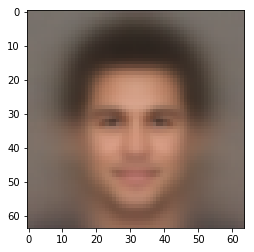

In [66]:
s1 = torch.tensor([[1,1]])
print(s1.size())
x, y = data_load_new(batchsize=1, s=s1)

ve_mu, ve_var = CM_gen.Voice_Encoder(x.to(DEVICE))


reparam_VE = CM_gen.reparameterize(ve_mu, ve_var)

recon_image_mu, recon_image_var = CM_gen.Face_Decoder(reparam_VE, xx)
#print(recon_image_mu)
recon_image = CM_gen.reparameterize(recon_image_mu, recon_image_var)
#print(recon_image)

recon1 = recon_image.view(3,64,64)

recon1 = recon1.transpose(0,2)

recon1 = recon1.transpose(0,1)

y11 = recon1.to('cpu')
plt.imshow(y11.detach().numpy())

In [114]:
CM_gen.Face_Classifier(recon_image)

tensor([[0., 0., 1., 0.]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [115]:
s1 = torch.tensor([[0,1]])
print(s1.size())
x, y = data_load_new(batchsize=1, s=s1)

torch.Size([1, 2])


In [117]:
x = x.to('cuda')

CM_gen.Voice_Classifier(x)

tensor([[0., 0., 0., 0.]], device='cuda:0', grad_fn=<ViewBackward>)

In [91]:
##female young to male young

voice_path_s = '/home/ubuntu/project2/voice_cvae/vcc2018/VCC2SF1/'
file='10001.wav'
voice_path_t = '/home/ubuntu/project2/voice_cvae/vcc2018/VCC2SM1/'

output_voice_path= '/home/ubuntu/project2/voice_cvae/converted_voices/'

source_dir = 'VCC2SF1'
target_dir =  'VCC2SM1'


In [92]:
face_path_s = '/home/ubuntu/project2/CELEBA_DATA/MY_test/'
#face_path_t = '/home/ubuntu/project2/CELEBA_DATA/FY_test/'
face_file_s =  '004087.jpg'
#face_file_s=   '006996.jpg'

In [109]:
##male young to female old
voice_path_s = '/home/ubuntu/project2/voice_cvae/vcc2018/VCC2SM1/'
file='10015.wav'
voice_path_t = '/home/ubuntu/project2/voice_cvae/vcc2018/VCC2SF4/'

output_voice_path= '/home/ubuntu/project2/voice_cvae/converted_voices/'

source_dir = 'VCC2SM1'
target_dir =  'VCC2SF4'

In [110]:
face_path_s = '/home/ubuntu/project2/CELEBA_DATA/FO_test/'
face_file_s=   '000381.jpg'

In [111]:
mode = 'test'
batch_size = 4
num_workers=1
crop_size=178
image_size=64

transform = []
if mode == 'train':
    transform.append(T.RandomHorizontalFlip())
transform.append(T.CenterCrop(crop_size))
transform.append(T.Resize(image_size))
transform.append(T.ToTensor())
#transform.append(T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)))
transform = T.Compose(transform)

#image_target = Image.open(os.path.join(face_path_t, face_file_t))

image_source = Image.open(os.path.join(face_path_s, face_file_s )) 

#face_target = transform(image_target)

#face_target = face_target.unsqueeze(0)


face_source = transform(image_source)

face_source = face_source.unsqueeze(0)

In [112]:
wav, _ = librosa.load(os.path.join(voice_path_s, file), sr = sampling_rate, mono = True)
wav = librosa.util.normalize(wav, norm=np.inf, axis=None)
wav = wav_padding(wav = wav, sr = sampling_rate, frame_period = frame_period, multiple = 4)
f0, timeaxis, sp, ap, mc = world_decompose(wav = wav, fs = sampling_rate, frame_period = frame_period)


mc_transposed  = np.array(mc).T

mcep_normalization_params_s = np.load(os.path.join(voice_path_s, "mcep_"+source_dir+".npz"))
mcep_mean_s = mcep_normalization_params_s['mean']
mcep_std_s = mcep_normalization_params_s['std']    
mcep_normalization_params_t = np.load(os.path.join(voice_path_t, "mcep_"+target_dir+".npz"))
mcep_mean_t = mcep_normalization_params_t['mean']
mcep_std_t = mcep_normalization_params_t['std']

mc_norm = (mc_transposed - mcep_mean_s) / mcep_std_s

x = torch.Tensor(mc_norm).view(1, 1, mc_norm.shape[0], mc_norm.shape[1])

n_frames=1024
frames = np.shape(mc_transposed)[1]
# #print(frames)
start_ = np.random.randint(frames - n_frames + 1)
end_ = start_ + n_frames
x=x[:,:,:,start_:end_]


x = x.to(DEVICE)
#face_target= face_target.to(DEVICE)

face_source = face_source.to(DEVICE)



#(face,_) in data_iter

CM_gen.eval()

UE_mu, UE_var = CM_gen.Utterance_Encoder(x)
FE_mu, FE_var = CM_gen.Face_Encoder(face_target)
reparam_UE = CM_gen.reparameterize(UE_mu, UE_var)
reparam_FE = CM_gen.reparameterize(FE_mu, FE_var)
UD_mu, UD_var = CM_gen.Utterance_Decoder(reparam_UE,reparam_FE)
recon_voice = CM_gen.reparameterize(UD_mu, UD_var)


FE_mu_s, FE_var_s = CM_gen.Face_Encoder(face_source)
reparam_FE_s = CM_gen.reparameterize(FE_mu_s, FE_var_s)
UD_mu_s, UD_var_s = CM_gen.Utterance_Decoder(reparam_UE,reparam_FE_s)
recon_voice_s = CM_gen.reparameterize(UD_mu_s, UD_var_s)


if (torch.cuda.is_available()):
    z_dec_s = recon_voice_s.data.cpu().numpy().reshape((mc_norm.shape[0], n_frames))
else:
    z_dec_s = recon_voice_s.data.numpy().reshape((mc_norm.shape[0], n_frames))


if (torch.cuda.is_available()):
    z_dec_t = recon_voice.data.cpu().numpy().reshape((mc_norm.shape[0], n_frames))
else:
    z_dec_t = recon_voice.data.numpy().reshape((mc_norm.shape[0], n_frames))
    

    
mc_converted_t = z_dec_t * mcep_std_t + mcep_mean_t
mc_converted_t = mc_converted_t.T
mc_converted_t = np.ascontiguousarray(mc_converted_t)
sp_converted_t = world_decode_mc(mc = mc_converted_t, fs = sampling_rate)


mc_converted_s = z_dec_s * mcep_std_s + mcep_mean_s
mc_converted_s = mc_converted_s.T
mc_converted_s = np.ascontiguousarray(mc_converted_s)
sp_converted_s = world_decode_mc(mc = mc_converted_s, fs = sampling_rate)

sp = sp[:n_frames,:]

sp_gained = np.multiply(sp, np.divide(sp_converted_t, sp_converted_s))

logf0s_normalization_params_s = np.load(os.path.join(voice_path_s, "log_f0_"+source_dir+".npz"))
logf0s_mean_s = logf0s_normalization_params_s['mean']
logf0s_std_s = logf0s_normalization_params_s['std']


logf0s_normalization_params_t = np.load(os.path.join(voice_path_t, "log_f0_"+target_dir+".npz"))
logf0s_mean_t = logf0s_normalization_params_t['mean']
logf0s_std_t = logf0s_normalization_params_t['std']



ap=ap[:n_frames]



f0_converted = pitch_conversion(f0 = f0, mean_log_src = logf0s_mean_s, std_log_src = logf0s_std_s, mean_log_target = logf0s_mean_t, std_log_target = logf0s_std_t)

f0_converted = f0_converted[:n_frames]
wav_transformed = world_speech_synthesis(f0 = f0_converted, sp = sp_gained, ap = ap, fs = sampling_rate, frame_period = frame_period)
librosa.output.write_wav(os.path.join(output_voice_path, source_dir +"_to_"+target_dir+".wav"), wav_transformed, sampling_rate)


/home/ubuntu/project2/voice_cvae/preprocess.py:375: RuntimeWarning: divide by zero encountered in log
  f0_converted = np.exp((np.log(f0) - mean_log_src) / std_log_src * std_log_target + mean_log_target)
